# Backtest on the portfolio based on chapter 3 of Vorobets (2025)

In [16]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn yfinance

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Historical realization (a piece of numerous different scenarios)

Returns: 2470 days × 13 assets
Date range: 2016-01-05 → 2025-11-11

BACKTEST RESULTS (9.8 years)
Portfolio CAGR:  23.28%
Benchmark CAGR:  13.30%
Portfolio Vol:   17.01%
Benchmark Vol:   18.28%
Portfolio Sharpe: 1.37
Benchmark Sharpe: 0.73
Rebalancing events: 39


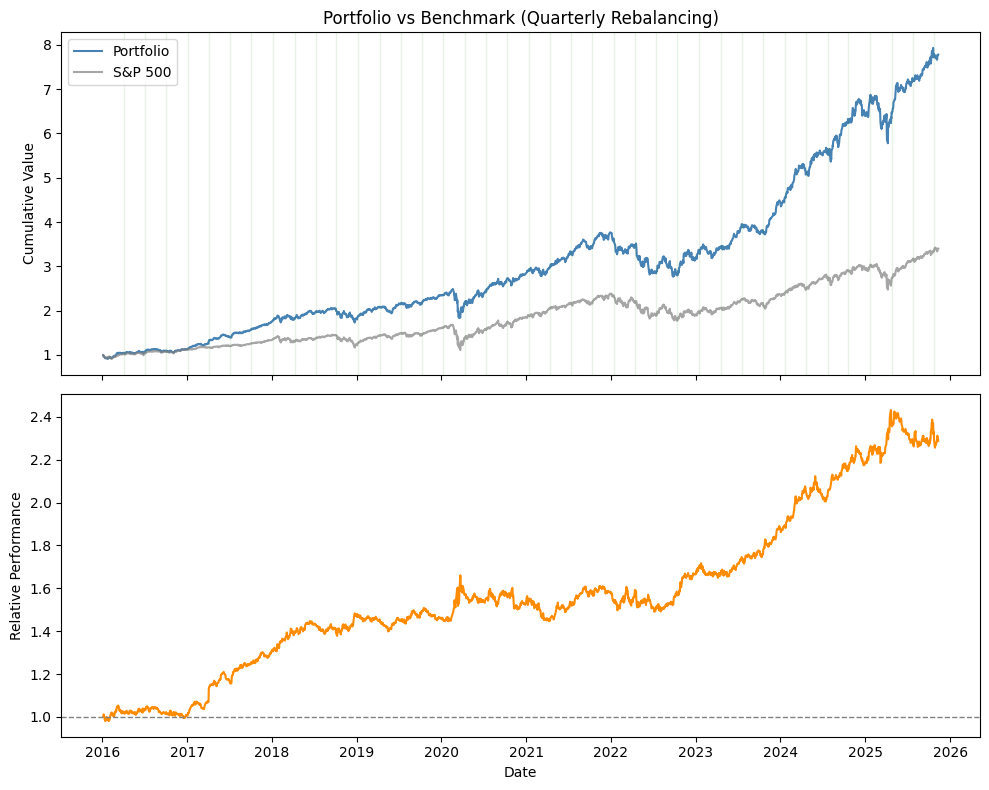

In [4]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    'NVDA', 'ISRG', 'APO', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]
benchmark = '^GSPC'

all_assets = selected_assets + [benchmark]
existing_assets = [c for c in all_assets if c in data.columns]
data = data[existing_assets]
data = data[data > 0].dropna()

# Target weights
target_weights = np.array([
    0.0413,  # NVDA
    0.0516,  # ISRG
    0.0414,  # APO
    0.0597,  # DECK
    0.1624,  # COST
    0.0901,  # CAT
    0.0240,  # BTU
    0.0992,  # SHW
    0.0790,  # NRG
    0.0707,  # NFLX
    0.0519,  # CBRE
    0.2286,  # GC=F
])

pnl = np.log(data / data.shift(1)).dropna()
asset_returns = pnl[selected_assets]
benchmark_returns = pnl[benchmark]

print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Date range: {pnl.index[0].date()} → {pnl.index[-1].date()}")

# Quarterly rebalancing backtest
rebal_freq = 63  # ~quarterly (63 trading days)

portfolio_value = [1.0]
benchmark_value = [1.0]
rebal_dates = []

weights = target_weights.copy()

for t in range(len(asset_returns)):
    # Daily return
    daily_ret = asset_returns.iloc[t].values
    port_ret = np.sum(weights * daily_ret)
    
    # Update portfolio value
    portfolio_value.append(portfolio_value[-1] * np.exp(port_ret))
    benchmark_value.append(benchmark_value[-1] * np.exp(benchmark_returns.iloc[t]))
    
    # Drift weights
    weights = weights * np.exp(daily_ret)
    weights = weights / weights.sum()
    
    # Rebalance quarterly
    if (t + 1) % rebal_freq == 0:
        weights = target_weights.copy()
        rebal_dates.append(asset_returns.index[t])

# Results
dates = [pnl.index[0]] + list(asset_returns.index)
results = pd.DataFrame({
    'Portfolio': portfolio_value,
    'Benchmark': benchmark_value
}, index=dates)

# Performance metrics
total_days = len(results) - 1
years = total_days / 252

port_cagr = (results['Portfolio'].iloc[-1] ** (1/years) - 1) * 100
bench_cagr = (results['Benchmark'].iloc[-1] ** (1/years) - 1) * 100
port_vol = pnl[selected_assets].values @ target_weights
port_vol = np.std(port_vol) * np.sqrt(252) * 100
bench_vol = benchmark_returns.std() * np.sqrt(252) * 100

print(f"\n{'='*50}")
print(f"BACKTEST RESULTS ({years:.1f} years)")
print(f"{'='*50}")
print(f"Portfolio CAGR:  {port_cagr:.2f}%")
print(f"Benchmark CAGR:  {bench_cagr:.2f}%")
print(f"Portfolio Vol:   {port_vol:.2f}%")
print(f"Benchmark Vol:   {bench_vol:.2f}%")
print(f"Portfolio Sharpe: {port_cagr/port_vol:.2f}")
print(f"Benchmark Sharpe: {bench_cagr/bench_vol:.2f}")
print(f"Rebalancing events: {len(rebal_dates)}")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(results.index, results['Portfolio'], label='Portfolio', color='steelblue')
axes[0].plot(results.index, results['Benchmark'], label='S&P 500', color='grey', alpha=0.7)
for rd in rebal_dates:
    axes[0].axvline(rd, color='green', alpha=0.1, lw=1)
axes[0].set_ylabel('Cumulative Value')
axes[0].legend()
axes[0].set_title('Portfolio vs Benchmark (Quarterly Rebalancing)')

axes[1].plot(results.index, results['Portfolio'] / results['Benchmark'], color='darkorange')
axes[1].axhline(1, color='grey', ls='--', lw=1)
axes[1].set_ylabel('Relative Performance')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Simulated Historical Paths, Quarterly Rebalncing 

In [5]:
pnl = np.log(data / data.shift(1)).dropna()
asset_returns = pnl[selected_assets].values
benchmark_returns = pnl[benchmark].values
dates = pnl.index

T = len(pnl)
I = len(selected_assets)
print(f"Returns: {T} days × {I} assets")

Returns: 2470 days × 12 assets


In [9]:
target_weights = np.array([
    0.0413,  # NVDA
    0.0516,  # ISRG
    0.0414,  # APO
    0.0597,  # DECK
    0.1624,  # COST
    0.0901,  # CAT
    0.0240,  # BTU
    0.0992,  # SHW
    0.0790,  # NRG
    0.0707,  # NFLX
    0.0519,  # CBRE
    0.2286,  # GC=F
])

H = 63  # Rebalancing frequency (quarterly)
S = 1000  # Number of synthetic paths

out_of_sample_years = 5
out_of_sample_obs = out_of_sample_years * 252
out_of_sample_quarters = out_of_sample_years * 4

np.random.seed(42)

print(f"Horizon: {H} days per quarter")
print(f"Synthetic paths: {S}")
print(f"Out-of-sample: {out_of_sample_years} years ({out_of_sample_obs} days, {out_of_sample_quarters} quarters)")

Horizon: 63 days per quarter
Synthetic paths: 1000
Out-of-sample: 5 years (1260 days, 20 quarters)


In [10]:
# Preallocate
portfolio_synth = np.ones((S, out_of_sample_obs + 1))
benchmark_synth = np.ones((S, out_of_sample_obs + 1))
portfolio_realized = np.ones(out_of_sample_obs + 1)
benchmark_realized = np.ones(out_of_sample_obs + 1)

# Out-of-sample data
oos_asset_returns = asset_returns[-out_of_sample_obs:]
oos_benchmark_returns = benchmark_returns[-out_of_sample_obs:]
oos_dates = dates[-out_of_sample_obs:]

for q in range(out_of_sample_quarters):
    # Time indices for this quarter
    t_start = q * H
    t_end = min((q + 1) * H, out_of_sample_obs)
    
    # In-sample data (expanding window)
    in_sample_end = T - out_of_sample_obs + t_start
    in_sample_asset = asset_returns[:in_sample_end]
    in_sample_bench = benchmark_returns[:in_sample_end]
    T_in = len(in_sample_asset)
    
    # Simulate S paths by resampling in-sample returns
    sim_indices = np.random.choice(T_in, size=(S, H), replace=True)
    
    for s in range(S):
        sim_asset_ret = in_sample_asset[sim_indices[s]]
        sim_bench_ret = in_sample_bench[sim_indices[s]]
        
        # Portfolio returns with target weights
        sim_port_ret = sim_asset_ret @ target_weights
        
        # Cumulative returns for this quarter
        for h in range(t_end - t_start):
            t = t_start + h
            portfolio_synth[s, t + 1] = portfolio_synth[s, t] * np.exp(sim_port_ret[h])
            benchmark_synth[s, t + 1] = benchmark_synth[s, t] * np.exp(sim_bench_ret[h])
    
    # Realized (historical) performance
    for t in range(t_start, t_end):
        port_ret = oos_asset_returns[t] @ target_weights
        bench_ret = oos_benchmark_returns[t]
        portfolio_realized[t + 1] = portfolio_realized[t] * np.exp(port_ret)
        benchmark_realized[t + 1] = benchmark_realized[t] * np.exp(bench_ret)

print(f"Backtest complete: {out_of_sample_quarters} quarters, {S} synthetic paths each")

Backtest complete: 20 quarters, 1000 synthetic paths each


In [11]:
years = out_of_sample_obs / 252

# Realized metrics
port_cagr = (portfolio_realized[-1] ** (1/years) - 1)
bench_cagr = (benchmark_realized[-1] ** (1/years) - 1)

port_daily_ret = np.diff(np.log(portfolio_realized))
bench_daily_ret = np.diff(np.log(benchmark_realized))
port_vol = np.std(port_daily_ret) * np.sqrt(252)
bench_vol = np.std(bench_daily_ret) * np.sqrt(252)

port_sharpe = port_cagr / port_vol
bench_sharpe = bench_cagr / bench_vol

# Drawdowns
port_cummax = np.maximum.accumulate(portfolio_realized)
bench_cummax = np.maximum.accumulate(benchmark_realized)
port_dd = (portfolio_realized - port_cummax) / port_cummax
bench_dd = (benchmark_realized - bench_cummax) / bench_cummax

# Synthetic path statistics
synth_final = portfolio_synth[:, -1]
synth_median = np.median(synth_final)
synth_5th = np.percentile(synth_final, 5)
synth_95th = np.percentile(synth_final, 95)

print(f"{'='*55}")
print(f"PERFORMANCE SUMMARY ({years:.1f} years)")
print(f"{'='*55}")
print(f"{'Metric':<20} {'Portfolio':>12} {'Benchmark':>12}")
print(f"{'-'*55}")
print(f"{'CAGR':<20} {port_cagr:>11.2%} {bench_cagr:>11.2%}")
print(f"{'Volatility':<20} {port_vol:>11.2%} {bench_vol:>11.2%}")
print(f"{'Sharpe Ratio':<20} {port_sharpe:>12.2f} {bench_sharpe:>12.2f}")
print(f"{'Max Drawdown':<20} {port_dd.min():>11.2%} {bench_dd.min():>11.2%}")
print(f"{'Final Value':<20} {portfolio_realized[-1]:>12.2f} {benchmark_realized[-1]:>12.2f}")
print(f"{'-'*55}")
print(f"{'SYNTHETIC PATHS':^55}")
print(f"{'-'*55}")
print(f"{'Median Final':<20} {synth_median:>12.2f}")
print(f"{'5th Percentile':<20} {synth_5th:>12.2f}")
print(f"{'95th Percentile':<20} {synth_95th:>12.2f}")

PERFORMANCE SUMMARY (5.0 years)
Metric                  Portfolio    Benchmark
-------------------------------------------------------
CAGR                      25.03%      15.92%
Volatility                16.60%      16.99%
Sharpe Ratio                 1.51         0.94
Max Drawdown             -25.98%     -25.43%
Final Value                  3.06         2.09
-------------------------------------------------------
                    SYNTHETIC PATHS                    
-------------------------------------------------------
Median Final                 2.65
5th Percentile               1.43
95th Percentile              4.99


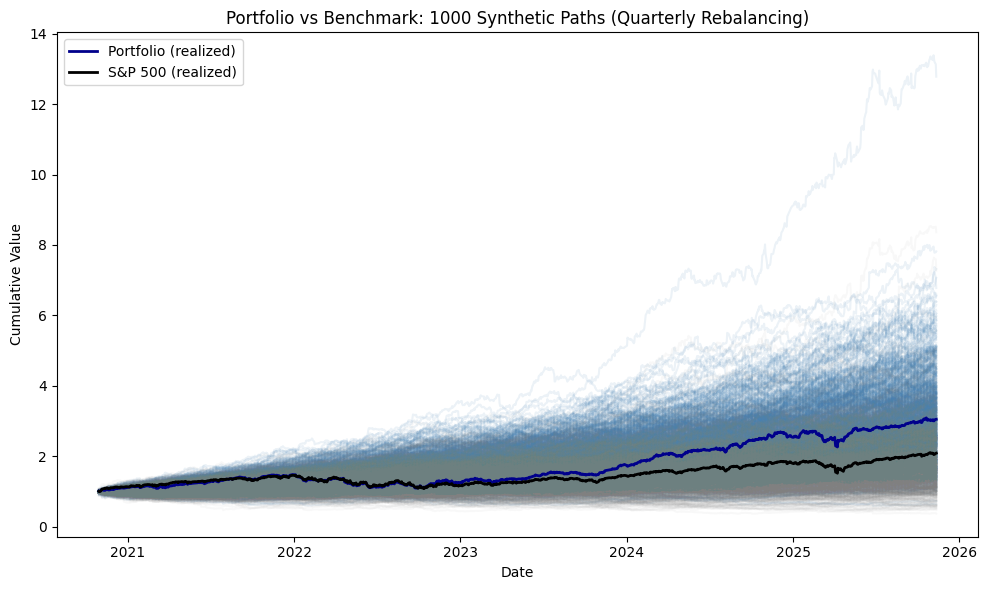

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Synthetic paths
ax.plot(oos_dates, portfolio_synth[:, 1:].T, color='steelblue', alpha=0.1)
ax.plot(oos_dates, benchmark_synth[:, 1:].T, color='grey', alpha=0.05)

# Realized paths
ax.plot(oos_dates, portfolio_realized[1:], color='darkblue', lw=2, label='Portfolio (realized)')
ax.plot(oos_dates, benchmark_realized[1:], color='black', lw=2, label='S&P 500 (realized)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Value')
ax.set_title(f'Portfolio vs Benchmark: {S} Synthetic Paths (Quarterly Rebalancing)')
ax.legend()
plt.tight_layout()
plt.show()

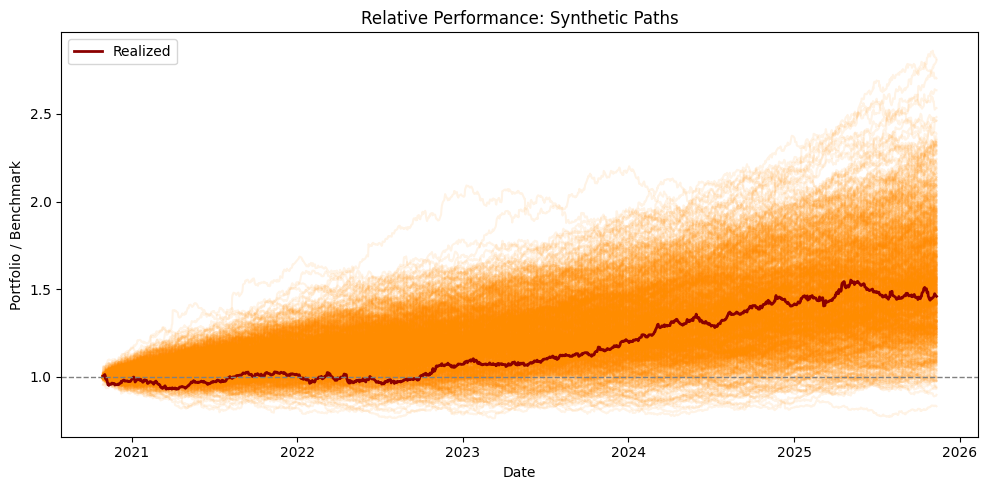

In [13]:
relative_synth = portfolio_synth / benchmark_synth
relative_realized = portfolio_realized / benchmark_realized

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(oos_dates, relative_synth[:, 1:].T, color='darkorange', alpha=0.1)
ax.plot(oos_dates, relative_realized[1:], color='darkred', lw=2, label='Realized')
ax.axhline(1, color='grey', ls='--', lw=1)

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio / Benchmark')
ax.set_title('Relative Performance: Synthetic Paths')
ax.legend()
plt.tight_layout()
plt.show()

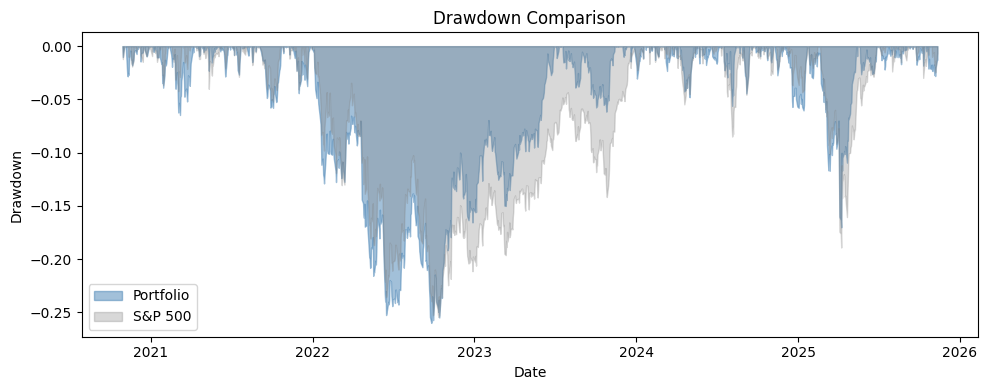

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.fill_between(oos_dates, port_dd[1:], 0, alpha=0.5, color='steelblue', label='Portfolio')
ax.fill_between(oos_dates, bench_dd[1:], 0, alpha=0.3, color='grey', label='S&P 500')

ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.set_title('Drawdown Comparison')
ax.legend()
plt.tight_layout()
plt.show()

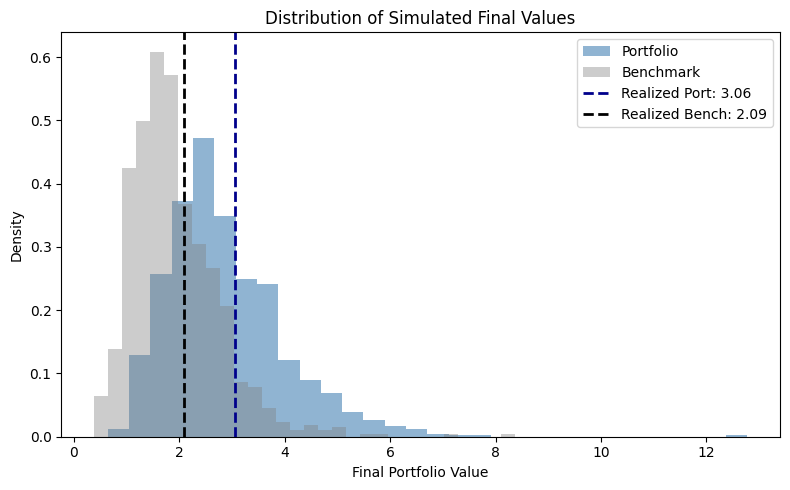

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(portfolio_synth[:, -1], bins=30, alpha=0.6, color='steelblue', label='Portfolio', density=True)
ax.hist(benchmark_synth[:, -1], bins=30, alpha=0.4, color='grey', label='Benchmark', density=True)
ax.axvline(portfolio_realized[-1], color='darkblue', lw=2, ls='--', label=f'Realized Port: {portfolio_realized[-1]:.2f}')
ax.axvline(benchmark_realized[-1], color='black', lw=2, ls='--', label=f'Realized Bench: {benchmark_realized[-1]:.2f}')

ax.set_xlabel('Final Portfolio Value')
ax.set_ylabel('Density')
ax.set_title('Distribution of Simulated Final Values')
ax.legend()
plt.tight_layout()
plt.show()